In [1]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sn
import matplotlib.pyplot as plt
import language_tool_python
import scipy.stats as stats

tool = language_tool_python.LanguageTool('en-US')
is_bad_rule = lambda rule: rule.message == 'Possible spelling mistake found.' and len(rule.replacements) and rule.replacements[0][0].isupper()

## Data importation

In [2]:
df_free = pd.read_csv('data/free_text_typing_dataset.csv', sep=';')
df_freq = pd.read_csv('data/frequency_dataset.csv', sep=';')
df_user = pd.read_csv('data/participants_information.csv', sep=';')

df_free = df_free.rename(columns={'userid':'userId'})
df_freq = df_freq.rename(columns={'User ID':'userId'})

## Sentences reconstruction and feature extraction

In [3]:
# reconstruct users' sentences from the keycode in df_free

sentence = ''
uppercase = False
uppercase_tmp = False
i_start = 0
i_end = 0
text_free = pd.DataFrame(columns=['sentence', 'idx_start', 'idx_end'])

df_free.keyCode = df_free.keyCode.astype(str)

for i in range(len(df_free)):
    if i > 0 and (df_free.userId[i] != df_free.userId[i-1] or df_free.emotionIndex[i] != df_free.emotionIndex[i-1]): #df_free._id[i][:-2] != df_free._id[i-1][:-2]:
        i_end = i-1
        if len(sentence) > 1 and sentence[0].islower() and sentence[1].isupper():
            sentence = sentence.swapcase()
        text_free = text_free.append(pd.DataFrame([[sentence, i_start, i_end]], columns=['sentence', 'idx_start', 'idx_end']), ignore_index = True)
        i_start = i
        sentence = ''
        uppercase = False
        uppercase_tmp = False
    if df_free.keyCode[i] == '\\b':   # delete key
        sentence = sentence[:max(0,len(sentence)-1)]
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == '\\u0014':   # caps lock key
        uppercase = not uppercase
        continue
    if df_free.keyCode[i] == '\\u0010' and not uppercase:   # shift key
        uppercase_tmp = True
        continue
    if df_free.keyCode[i] == '¼':     # comma key
        sentence += ','
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == 'ß':     # exclamation mark key
        sentence += '!'
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == '¾':   # dot key
        sentence += '.'
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == '4    ':   # apostrophe key
        sentence += "'"
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == '6    ':    # dash key
        sentence += "-"
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == '¿':   # colon key
        sentence += ":"
        uppercase_tmp = False
        continue
    if uppercase:
        sentence += df_free.keyCode[i].upper()
        continue
    if uppercase_tmp:
        sentence += df_free.keyCode[i].upper()
        uppercase_tmp = False
        continue
    sentence += df_free.keyCode[i]    

text_free = text_free.append(pd.DataFrame([[sentence, i_start, i]], columns=['sentence', 'idx_start', 'idx_end']), ignore_index = True)

In [4]:
# drop features highly correlated  with other features
df_free = df_free.drop(['D1U3','D1D3'], axis=1)
df_free.head()

,_id,userId,emotionIndex,index,keyCode,keyDown,keyUp,D1U1,D1U2,D1D2,U1D2,U1U2,answer
0,5e1e2631d2dd163d472fd5ac,100,N,822,\u0011,"1,57903E+12","1,57903E+12",982,764,709.0,-273,-218,NaN
1,5e1e2631d2dd163d472fd5ad,100,N,823,v,"1,57903E+12","1,57903E+12",55,"-1,57903E+12",23415.0,23360,"-1,57903E+12",NaN
2,5e1e2631d2dd163d472fd5ae,100,N,824,\b,"1,57903E+12",NaN,"-1,57903E+12","-1,57903E+12",607.0,"1,57903E+12",0,NaN
3,5e1e2631d2dd163d472fd5af,100,N,825,\b,"1,57903E+12",NaN,"-1,57903E+12","-1,57903E+12",35.0,"1,57903E+12",0,NaN
4,5e1e2631d2dd163d472fd5b0,100,N,826,\b,"1,57903E+12",NaN,"-1,57903E+12","-1,57903E+12",42.0,"1,57903E+12",0,NaN


In [5]:
# functions to extract features from the df_free table
def extract_editDistance_free(sentence):
    matches = tool.check(sentence)
    matches = [rule for rule in matches if not is_bad_rule(rule)]
    correct = language_tool_python.utils.correct(sentence, matches)
    return nltk.edit_distance(sentence, correct)

def extract_nbKeystroke(val, start, end):
    return val[end] - val[start] + 1

def extract_mean(val, start, end):
    return np.mean(val[start:end+1])

def extract_std(val, start, end):
    return np.std(val[start:end+1])

def extract_answer(val, start, end):
    for i in range(start, end+1):
        if val[i] != np.nan:
            return val[i]
    return np.nan

In [6]:
key_features = ['D1U1','D1U2','D1D2','U1D2','U1U2']

text_free['userId'] = df_free.userId[text_free.idx_start].values
text_free['emotionIndex'] = df_free.emotionIndex[text_free.idx_start].values
text_free = text_free.reindex(columns=['idx_start','idx_end','userId','emotionIndex','sentence'])
text_free['editDistance'] = text_free.apply(lambda x: extract_editDistance_free(x['sentence']), axis=1)
text_free['nbKeystroke'] = text_free.apply(lambda x: extract_nbKeystroke(df_free.index, x['idx_start'], x['idx_end']), axis=1)
text_free['answer'] = text_free.apply(lambda x: extract_answer(df_free.answer, x['idx_start'], x['idx_end']), axis=1)

for feat in key_features:
    df_free[feat] = df_free[feat].apply(lambda x: np.nan if np.abs(x) > 1570000000000 else x)
    text_free[feat+'_mean'] = text_free.apply(lambda x: extract_mean(df_free[feat], x['idx_start'], x['idx_end']), axis=1)
    text_free[feat+'_std'] = text_free.apply(lambda x: extract_std(df_free[feat], x['idx_start'], x['idx_end']), axis=1)


text_free.head()

UFuncTypeError: ufunc 'absolute' did not contain a loop with signature matching types <class 'numpy.dtypes.StrDType'> -> None

[]

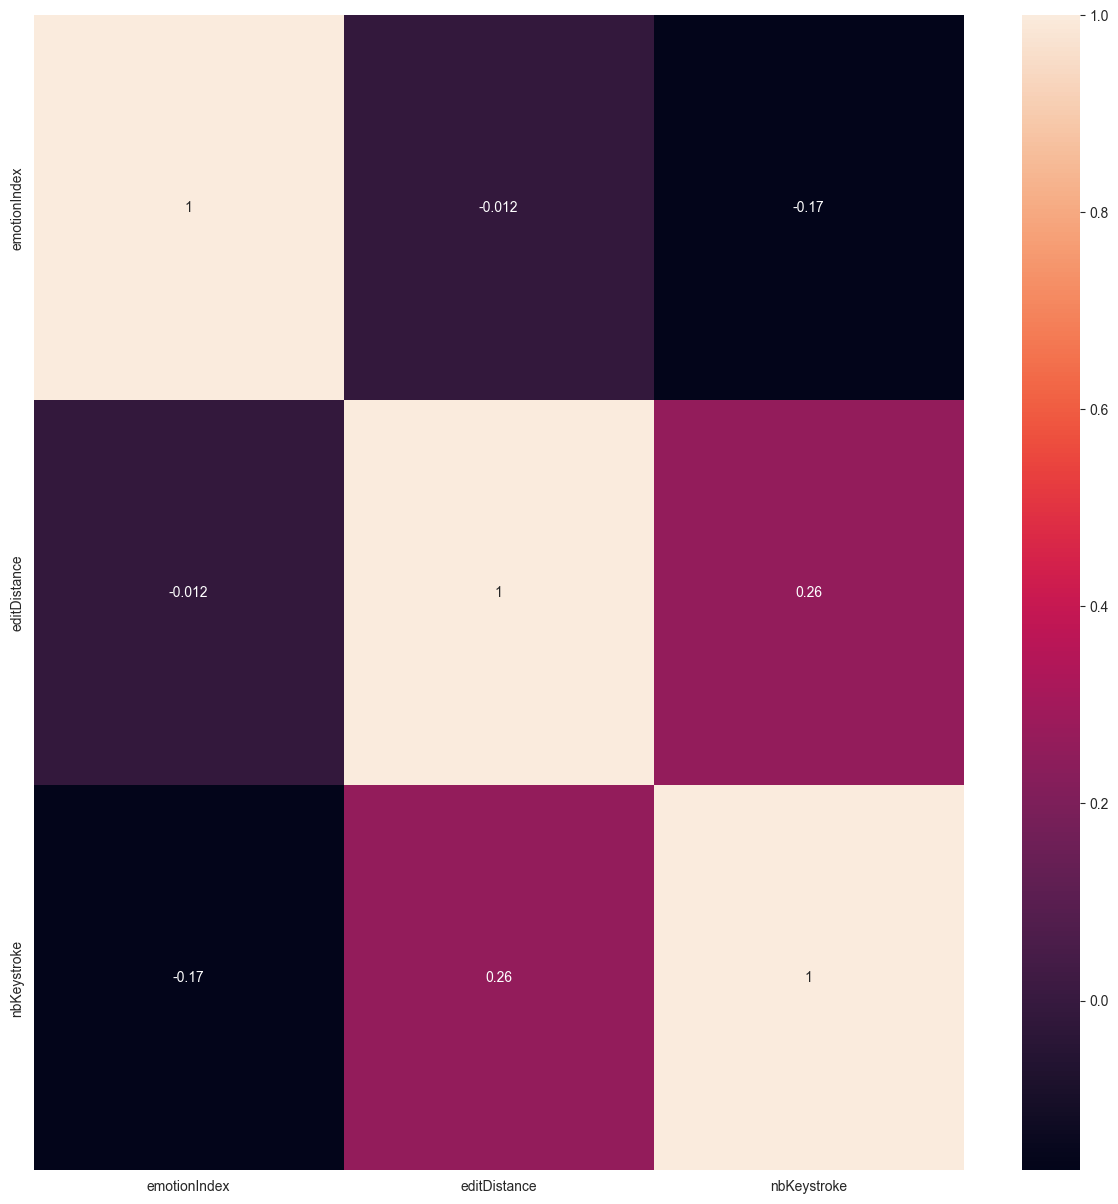

In [7]:
## correlation matrix

# Numeric columns of the dataset
text_free.emotionIndex = text_free.emotionIndex.map({'N':0,'H':1,'C':2,'S':3,'A':4})
numeric_col = ['emotionIndex','editDistance','nbKeystroke'] + [col for col in text_free.columns if '_mean' in col] + [col for col in text_free.columns if '_std' in col]

# Correlation Matrix formation
corr_matrix = text_free.loc[:, numeric_col].corr()
text_free.emotionIndex = text_free.emotionIndex.map({0:'N',1:'H',2:'C',3:'S',4:'A'})
 
#Using heatmap to visualize the correlation matrix
plt.figure(figsize = (15,15))
sn.heatmap(corr_matrix, annot=True)
plt.plot()

## Join tables: text_free with df_freq_free

In [8]:
# filter free-text experiments in df_freq
df_freq_free = df_freq[df_freq.textIndex == 'FR'].reset_index(drop=True)

In [9]:
# correction of expections to align df_freq_free and text_free tables
text_free.loc[43,'userId'] = 94
tmp = text_free.loc[29]
text_free.loc[29] = text_free.loc[30]
text_free.loc[30] = tmp

In [10]:
# alignment of df_freq_free and text_free tables
text_free['text_index'] = -1
df_freq_free['text_index'] = -1
index = 0

i = 0
j = 0
while i<len(df_freq_free) and j<len(text_free):
    if df_freq_free.userId[i] == text_free.userId[j] and df_freq_free.emotionIndex[i] == text_free.emotionIndex[j]:
        df_freq_free.loc[i,'text_index'] = index
        text_free.loc[j,'text_index'] = index
        index += 1
        i += 1
        j += 1
    elif j != len(text_free)-1 and df_freq_free.userId[i] == text_free.userId[j+1] and df_freq_free.emotionIndex[i] == text_free.emotionIndex[j+1]:
        df_freq_free.loc[i,'text_index'] = index
        text_free.loc[j+1,'text_index'] = index
        index += 1
        i += 1
        j += 2
    elif i != len(df_freq_free)-1 and df_freq_free.userId[i+1] == text_free.userId[j] and df_freq_free.emotionIndex[i+1] == text_free.emotionIndex[j]:
        df_freq_free.loc[i+1,'text_index'] = index
        text_free.loc[j,'text_index'] = index
        index += 1
        i += 2
        j += 1
    else:
        i += 1
        j += 1

In [ ]:
# correction of expections to align df_freq_free and df_user tables
tmp = df_user.loc[10]
df_user.loc[10] = df_user.loc[11]
df_user.loc[11] = tmp
tmp = df_user.loc[70]
df_user.loc[70] = df_user.loc[71]
df_user.loc[71] = tmp
tmp = df_user.loc[91]
df_user.loc[91] = df_user.loc[92]
df_user.loc[92] = tmp

In [11]:
# alignment of df_freq_free and df_user tables
df_freq_free['user_index'] = -1
index = 0

j = 0
for i in range(len(df_freq_free)):
    if i in [20,38,58,68,129,139,150,154,173,225,227]: 
        j += 1
    if j < len(df_user) and df_freq_free.userId[i] == df_user.userId[j]:
        df_freq_free.loc[i,'user_index'] = j
        i += 1
    else:
        if j < len(df_user)-1 and df_freq_free.userId[i] == df_user.userId[j+1]:
            df_freq_free.loc[i,'user_index'] = j+1
            i += 1
            j += 1
        else:
            for k in range(1,7):
                if df_freq_free.userId[i] == df_freq_free.userId[i-k]:
                    df_freq_free.loc[i,'user_index'] = df_freq_free.loc[i-k,'user_index']
                    break

In [12]:
# merge all tables
df_free_all = df_freq_free.join(text_free, on='text_index', how='left', rsuffix='_right')
df_free_all = df_free_all.drop(['userId_right', 'emotionIndex_right', 'text_index_right'], axis=1)
df_free_all = df_free_all.join(df_user.reset_index().rename(columns={'index':'user_index'}), on='user_index', how='left', rsuffix='_right')
df_free_all = df_free_all.drop(['user_index_right','userId_right'], axis=1)
df_free_all.head()

,userId,textIndex,emotionIndex,delFreq,leftFreq,TotTime,text_index,user_index,idx_start,idx_end,...,nbKeystroke,answer,typeWith,typistType,pcTimeAverage,ageRange,gender,status,degree,country
0,100,FR,N,145,0,NaN,0,0,0,147,...,148,NaN,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
1,100,FR,H,0,0,NaN,1,0,148,204,...,57,R,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
2,113,FR,N,44,0,NaN,2,1,205,329,...,125,NaN,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
3,113,FR,C,24,0,NaN,3,1,330,428,...,99,NaN,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
4,113,FR,H,15,0,NaN,4,1,429,483,...,55,R,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia


## Data analysis

### Useful functions

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics, model_selection
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import shap
from tqdm import trange

In [14]:
# Receiving a dictionary of performance metrics and printing them
def show_metrics(performance_metrics):
    for metric_name, metric in performance_metrics.items():
        if metric_name.startswith("Confusion"):
            print("Confusion Matrix: ")
            if len(metric) != 5:
                print(pd.DataFrame(metric))
            else:
                print(pd.DataFrame(metric, 
                  index=list(label_dictionary.values()), 
                  columns=list(label_dictionary.values())))
        else:
            print("Metric : % s, Score : % 5.2f" %(metric_name, metric))  

In [15]:
# Plotting the Confusion Matrix as a heatmap
label_dictionary = {1: 'N', 2: 'H', 3: 'C', 4: 'S', 5: 'A'}

def plot_confusion_matrix(confusion_matrix):
    if len(confusion_matrix) != 5:
        df_cm = pd.DataFrame(confusion_matrix)
    else:
        df_cm = pd.DataFrame(confusion_matrix, 
                         index = [i for i in label_dictionary.values()],
                         columns = [i for i in label_dictionary.values()])
    plt.figure()
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues")
    plt.show()

In [16]:
# Computing the different Performance Metrics
def compute_metrics(clf, dataX, dataY, show=False):
    # Using Confusion Metrics to compute metrics
    def performance_measures(y_true, y_pred):
        cnf_matrix = metrics.confusion_matrix(y_true, y_pred, normalize='true')

        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)

        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)

        acc = np.mean((TP + TN) / (TP + FP + FN + TN))
        TP_rate = np.mean(TP / (TP + FN))
        FP_rate = np.mean(FP / (FP + TN))
        precision = np.mean(TP / (TP + FP))
        f_measure = 2 * precision * TP_rate / (precision + TP_rate)
        f_micro = metrics.f1_score(y_true, y_pred, average='micro')
        f_macro = metrics.f1_score(y_true, y_pred, average='macro')
        
        # Returning 
        return (acc, TP_rate, FP_rate, precision, f_measure, f_micro, f_macro,
                np.round(cnf_matrix, 2))

    acc, tp_rate, fp_rate, precision, f_measure, f_micro, f_macro, confusion_matrix = performance_measures(y_true=dataY, y_pred=clf.predict(dataX))
    
    
    performance_metrics = {"ACC": acc, "TP_Rate": tp_rate, "FP_Rate": fp_rate,
            "Precision": precision, "F_Measure": f_measure, "F_Micro": f_micro, "F_Macro": f_macro,
            "Confusion Matrix": confusion_matrix} 
    if show:
        show_metrics(performance_metrics)

    return performance_metrics

### Data pre-processing

In [17]:
data_free = df_free_all.loc[:,df_free_all.columns.difference(['user_index','answer','emotionIndex','userId','textIndex','TotTime','text_index','idx_start','idx_end','sentence'])]
label_free = df_free_all.emotionIndex.map({'N':0,'H':1,'C':2,'S':3,'A':4})

In [18]:
# convert categorical features into numerical features
data_free.gender = (data_free.gender == 'Male')
data_free.ageRange = data_free.ageRange.map({'16-19':1,'20-29':2,'30-39':3,'>=50':4})
data_free.degree = data_free.degree.map({'High School':1, 'College/University':2})
data_free.pcTimeAverage = data_free.pcTimeAverage.map({'less than an hour per day':1, 'between 1 hour and 3 hours per day':2, 'More than 3 hours per day':3})
data_free.status = data_free.status.map({'Student':1, 'Professional':2})
data_free.typeWith = data_free.typeWith.map({'1 hand':1, '2 hands':2})
data_free = pd.get_dummies(data_free, columns=['country','typistType'])
data_free = data_free.fillna(-1)

In [19]:
data_free_filter = data_free
#label_free = (label_free == 1)  ## for binary models

### Statistical analysis

In [20]:
data_free.D1U2_mean.describe()

AttributeError: 'DataFrame' object has no attribute 'D1U2_mean'

In [21]:
# only for demographic features
personal_col = ['typeWith','gender','ageRange','degree','pcTimeAverage','status','country','typistType']
for col in personal_col:
    anova = stats.f_oneway(data_free.loc[data_free.D1U2_mean < 372, col],
               data_free.loc[(data_free.D1U2_mean >= 372) & (data_free.D1U2_mean < 446), col],
               data_free.loc[(data_free.D1U2_mean >= 446) & (data_free.D1U2_mean < 574), col],
               data_free.loc[data_free.D1U2_mean >= 574, col])
    print(col + ': ' + str(anova))

AttributeError: 'DataFrame' object has no attribute 'D1U2_mean'

### Multi-class models

In [22]:
#define classification models
classifiers_name = ['LogReg','RF','XGB','SVM','MLP']

classifiers = [
    LogisticRegression(multi_class='auto', max_iter=500, solver='newton-cg', class_weight={0:0.1,1:1,2:1,3:1,4:1}), 
    RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0:0.1,1:1,2:1,3:1,4:1}),
    xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss',use_label_encoder=False),
    SVC(kernel='rbf',decision_function_shape='ovr', probability=True),#, class_weight={0:0.1,1:1,2:1,3:1,4:1}),
    MLPClassifier(alpha=1, max_iter=500)]

In [23]:
# micro-F1 scores with a 10-fold cross-validation method

model_scores_micro = {}
for i in range(len(classifiers)):
    model_scores_micro[classifiers_name[i]] = []
    print(classifiers_name[i])
    for j in range(10):
        model = classifiers[i]
        scores = model_selection.cross_val_score(model, X=data_free_filter, y=label_free, cv=10, n_jobs=1, scoring='f1_micro')
        model_scores_micro[classifiers_name[i]] += list(scores)
    mean = np.nanmean(model_scores_micro[classifiers_name[i]])
    std = np.nanstd(model_scores_micro[classifiers_name[i]])
    model_scores_micro[classifiers_name[i]] = [mean,std]

model_scores_micro

LogReg


C:\Users\Lara\Documents\EmotionRecognitionKeystrokeDynamics\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Lara\Documents\EmotionRecognitionKeystrokeDynamics\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Lara\Documents\EmotionRecognitionKeystrokeDynamics\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Lara\Do

RF
XGB
SVM
MLP


{'LogReg': [0.15706521739130436, 0.045072303578633274],
 'RF': [0.171231884057971, 0.08191470505099609],
 'XGB': [0.3536231884057971, 0.09194906948937653],
 'SVM': [0.47663043478260875, 0.014525551656087758],
 'MLP': [0.4336594202898551, 0.09044765010882228]}

In [24]:
# macro-F1 scores with a 10-fold cross-validation method

model_scores_macro = {}
for i in range(len(classifiers)):
    model_scores_macro[classifiers_name[i]] = []
    print(classifiers_name[i])
    for j in range(10):
        model = classifiers[i]
        scores = model_selection.cross_val_score(model, X=data_free_filter, y=label_free, cv=10, n_jobs=1, scoring='f1_macro')
        model_scores_macro[classifiers_name[i]] += list(scores)
    mean = np.nanmean(model_scores_macro[classifiers_name[i]])
    std = np.nanstd(model_scores_macro[classifiers_name[i]])
    model_scores_macro[classifiers_name[i]] = [mean,std]

model_scores_macro

LogReg


C:\Users\Lara\Documents\EmotionRecognitionKeystrokeDynamics\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Lara\Documents\EmotionRecognitionKeystrokeDynamics\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Lara\Documents\EmotionRecognitionKeystrokeDynamics\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Lara\Do

RF
XGB
SVM
MLP


{'LogReg': [0.12813727383727386, 0.046913120916078396],
 'RF': [0.14074586054468408, 0.07717508132182908],
 'XGB': [0.1755743289848553, 0.044239064801387125],
 'SVM': [0.1290868347338935, 0.002659241598887632],
 'MLP': [0.15829428865063797, 0.047281166911656736]}

#### Best multi-class model

Metric : ACC, Score :  0.69
Metric : TP_Rate, Score :   nan
Metric : FP_Rate, Score :  0.19
Metric : Precision, Score :  0.24
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.38
Metric : F_Macro, Score :  0.20
Confusion Matrix: 
      N     H     C     S     A
N  0.64  0.08  0.08  0.16  0.04
H  0.57  0.00  0.00  0.00  0.43
C  0.17  0.00  0.17  0.50  0.17
S  0.33  0.33  0.00  0.11  0.22
A  0.00  0.00  0.00  0.00  0.00


C:\Users\Lara\AppData\Local\Temp\ipykernel_46792\1964377520.py:18: RuntimeWarning: invalid value encountered in divide
  TP_rate = np.mean(TP / (TP + FN))


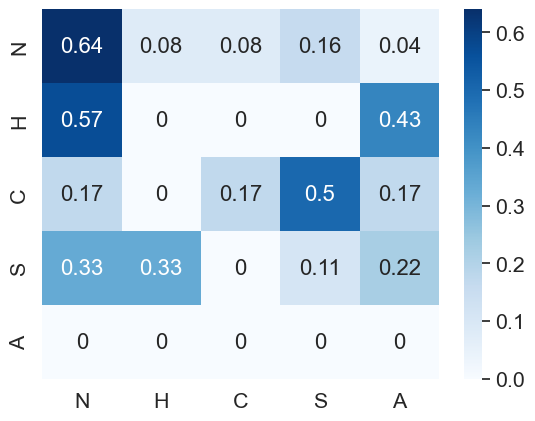

In [25]:
best_model = 'XGB'
X_train, X_test, Y_train, Y_test = train_test_split(data_free_filter, label_free, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

### Binary classification

In [26]:
## binary classification with XGBoost
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])
    
    print("Class " + label_dictionary[emotion_index+1] + ":")
    label_free_binary = (label_free == emotion_index).astype(int)
    
    for i in range(10):
        model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='mlogloss',use_label_encoder=False)
        scores = model_selection.cross_validate(model, X=data_free_filter, y=label_free_binary, cv=10, n_jobs=1, scoring=['f1_micro','f1_macro','recall'])
        
        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])
        
    print(np.round(np.nanmean(f1_micro),3), np.round(np.nanstd(f1_micro),3))
    print(np.round(np.nanmean(f1_macro),3), np.round(np.nanstd(f1_macro),3))
    print(np.round(np.nanmean(recall),3), np.round(np.nanstd(recall),3))
    
    print()
    print()

Class N:
0.6 0.094
0.593 0.099
0.608 0.192


Class H:
0.805 0.045
0.52 0.079
0.133 0.135


Class C:
0.813 0.038
0.479 0.062
0.058 0.118


Class S:
0.838 0.053
0.554 0.148
0.192 0.264


Class A:
0.859 0.059
0.495 0.11
0.05 0.15


In [27]:
## binary classification with Random Forest
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])
    
    print("Class " + label_dictionary[emotion_index+1] + ":")
    label_free_binary = (label_free == emotion_index).astype(int)
    
    for i in range(10):
        model = RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0:0.1,1:1})
        scores = model_selection.cross_validate(model, X=data_free_filter, y=label_free_binary, cv=10, n_jobs=1, scoring=['f1_micro','f1_macro','recall'])
        
        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])
        
    print(np.round(np.nanmean(f1_micro),3), np.round(np.nanstd(f1_micro),3))
    print(np.round(np.nanmean(f1_macro),3), np.round(np.nanstd(f1_macro),3))
    print(np.round(np.nanmean(recall),3), np.round(np.nanstd(recall),3))
    
    print()
    print()

Class N:
0.497 0.045
0.368 0.069
0.908 0.248


Class H:
0.582 0.15
0.421 0.101
0.277 0.315


Class C:
0.629 0.12
0.494 0.1
0.483 0.317


Class S:
0.62 0.165
0.502 0.112
0.599 0.299


Class A:
0.726 0.207
0.544 0.173
0.428 0.289


In [28]:
## binary classification with SVM
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])
    
    print("Class " + label_dictionary[emotion_index+1] + ":")
    label_free_binary = (label_free == emotion_index).astype(int)
    
    for i in range(10):
        model = SVC(kernel='rbf',decision_function_shape='ovr', probability=True)
        scores = model_selection.cross_validate(model, X=data_free_filter, y=label_free_binary, cv=10, n_jobs=1, scoring=['f1_micro','f1_macro','recall'])
        
        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])
        
    print(np.round(np.nanmean(f1_micro),3), np.round(np.nanstd(f1_micro),3))
    print(np.round(np.nanmean(f1_macro),3), np.round(np.nanstd(f1_macro),3))
    print(np.round(np.nanmean(recall),3), np.round(np.nanstd(recall),3))
    
    print()
    print()

Class N:
0.565 0.063
0.478 0.086
0.179 0.115


Class H:
0.847 0.018
0.459 0.005
0.0 0.0


Class C:
0.868 0.012
0.465 0.003
0.0 0.0


Class S:
0.864 0.015
0.463 0.005
0.0 0.0


Class A:
0.898 0.019
0.473 0.005
0.0 0.0



## Feature importance

In [29]:
scaler = MinMaxScaler()
data_free = pd.DataFrame(scaler.fit_transform(data_free), columns=data_free.columns)

#### Chi-squared

In [30]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

demo_features = np.array(['typeWith','gender','ageRange','degree','pcTimeAverage','status','country','typistType'])

# Feature extraction
test = SelectKBest(score_func=chi2, k=8)
fit = test.fit(data_free.loc[:,demo_features].fillna(100).replace(-1,16), pd.cut(data_free.D1U2_mean.fillna(0),bins=[0,372,445,573,4306],labels=[1,2,3,4]).fillna(1))

# Summarize scores
np.set_printoptions(precision=3)
print("Ordered features by importance with their corresponding chi2 score")
print(demo_features[np.argsort(fit.scores_)][::-1])
print(fit.scores_[np.argsort(fit.scores_)][::-1])

KeyError: "['country', 'typistType'] not in index"

#### Correlation coefficients

In [ ]:
importances = data_free.apply(lambda x: x.corr(data_free.D1U2_mean))
indices = np.argsort(importances)
indices_abs = np.argsort(np.abs(importances))[::-1]
print(importances[indices_abs])

In [ ]:
plt.figure(figsize=(10,10))
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), importances[indices].index.values)
plt.xlabel('Relative Importance')
plt.show()

#### Information Gain

In [ ]:
from info_gain import info_gain 

importances_ig = []
for col in data_free.columns:
    importances_ig.append(info_gain.info_gain(data_free[col],data_free.D1U2_mean))
indices_ig = np.argsort(importances_ig)[::-1]
pd.concat([pd.Series(data_free.columns[indices_ig]), pd.Series(np.sort(importances_ig)[::-1])], axis=1).set_index(0)

#### Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(data_free, data_free.D1U2_mean)
mi = pd.Series(mi)
mi.index = data_free.columns
mi.sort_values(ascending=False)
mi.sort_values(ascending=False).plot.bar(figsize=(10, 4))

#### Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000) 
rfe = RFE(model, 1)
fit = rfe.fit(data_free, label_free)

print("Feature Ranking: %s"% fit.ranking_)

In [ ]:
list(data_free.columns[fit.ranking_ - 1])

#### SHAP values

In [ ]:
# DF, based on which importance is checked
X_importance = pd.DataFrame(data_free_filter, columns=data_free_filter.columns)

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance, max_display=data_free.shape[1])

#### RF feature importance

In [ ]:
best_model = 'RF'
X_train, X_test, Y_train, Y_test = train_test_split(data_free, label_free, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

In [ ]:
plt.figure(figsize=(10,10))
pd.Series(model.feature_importances_, index=data_free.columns).nlargest(data_free.shape[1])[::-1].plot(kind='barh')
plt.show()

#### XGB feature importance

In [ ]:
best_model = 'XGB'
X_train, X_test, Y_train, Y_test = train_test_split(data_free, label_free, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

In [ ]:
plt.figure(figsize=(10,10))
pd.Series(model.feature_importances_, index=data_free.columns).nlargest(data_free.shape[1])[::-1].plot(kind='barh')
plt.show()